In [1]:
!pip install -r requirements.txt

In [22]:
import yaml
import numpy as np
import time
import tdmclient.notebook

In [23]:
#import scripts files
from scripts.vision import Vision
from scripts.global_nav import GlobalNav
from scripts.local_nav import LocalNav
from utils import utils

In [24]:
# Load the configuration file
with open('config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# time step
dt = config['time_step']

# Controller configuration
angle_tolerance = np.deg2rad(config['controller']['angle_tolerance']) 
distance_tolerance = config['controller']['distance_tolerance'] #mm
scale_rotation_speed = config['controller']['scale_rotation_speed'] 
max_rotation_speed = config['controller']['max_rotation_speed'] 
scale_translation_speed = config['controller']['scale_translation_speed'] 
min_translation_speed = config['controller']['min_translation_speed'] 
max_translation_speed = config['controller']['max_translation_speed'] 
kidnap_threshold = config['controller']['kidnap_threshold']
obstacles_max_iter = config['controller']['obstacles_max_iter']
obstacles_speed = config['controller']['obstacles_speed']
scale_sensor = config['controller']['scale_sensor']
weight_left = config['controller']['weight_left']
weight_right = config['controller']['weight_right']
scale_speed = config['controller']['scale_speed'] # thymio speed to mm/s taken from lab 8

# World configuration
world_width = config['world']['width'] #mm
world_height = config['world']['height'] #mm
obstacle_min_area = config['world']['obstacle_min_area'] #mm²
aruco_size = config['world']['aruco_size'] #mm

# Thymio configuration
thymio_size = config['thymio']['size'] #mm
security_margin = config['thymio']['margin'] #mm

# Webcam configuration
webcam_device_id = config['webcam']['device_id']
webcam_matrix = np.array(config['webcam']['matrix'])
webcam_distortion = np.array(config['webcam']['distortion'])
webcam_resolution = config['webcam']['resolution']
webcam_padding = config['webcam']['padding']
scale_factor = webcam_resolution[1] / world_width


In [4]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


In [5]:
@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [19]:
motor_move(50, 50)
time.sleep(1)
motor_stop()

In [25]:
vision = Vision(
    device_id=webcam_device_id,
    camera_matrix=webcam_matrix,
    dist_coeffs=webcam_distortion,
    resolution=webcam_resolution,
    padding=webcam_padding,
    scale_factor=scale_factor,
    world_width=world_width,
    world_height=world_height
    
)
global_nav = GlobalNav(
    world_width=world_width,
    world_height=world_height,
    obstacle_min_area=obstacle_min_area,
    thymio_size=thymio_size,
    security_margin=security_margin,
    scale_factor=scale_factor,
    aruco_size=aruco_size
    
)
local_nav = LocalNav(
    angle_threshold=angle_tolerance,
    distance_threshold=distance_tolerance,
    scale_rotation_speed=scale_rotation_speed,
    max_rotation_speed=max_rotation_speed,
    scale_translation_speed=scale_translation_speed,
    min_translation_speed=min_translation_speed,
    max_translation_speed=max_translation_speed,
    obstacles_max_iter=obstacles_max_iter,
    obstacles_speed=obstacles_speed,
    scale_sensor=scale_sensor,
    weight_left=weight_left,
    weight_right=weight_right
)

Vision Initialized
GlobalNav Initialized
LocalNav Initialized


'Found Trajectory!'

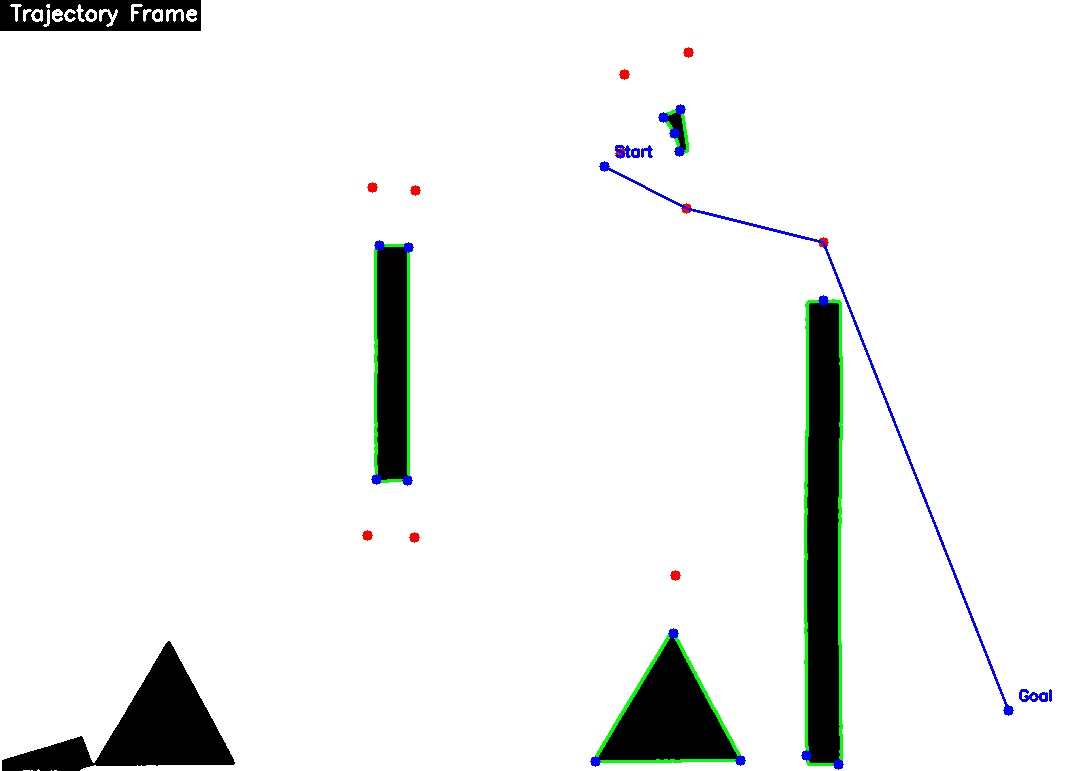

In [5]:
# Global variables
got_trajectory = False
trajectory_frame = None
trajectory_pos = None
obstacles_pos = None
thymio_init_pos = None
thymio_init_orientation = None

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    while not got_trajectory:
        original_frame, process_frame, thymio_init_pos, thymio_init_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
        
        if found_thymio and found_goal:
            trajectory_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_init_pos, goal_pos)

        utils.display_frames(original_frame, process_frame, None) 
        time.sleep(dt)
        
except KeyboardInterrupt:
    display("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.cleanup_webcam()
    time.sleep(1)
    if got_trajectory:
        display("Found Trajectory!")
    time.sleep(1)
    utils.display_frames(None, None, trajectory_frame)

In [6]:
if got_trajectory:
    obstacles_rounded = {k: np.round(v, 1) for k, v in obstacles_pos.items()}
    obstacles_formatted = '\n '.join([f"{k}: {v}" for k, v in obstacles_rounded.items()])
    print(f"Obstacles [mm]: \n {obstacles_formatted}")

    print(f"Trajectory points [mm]:\n {np.round(trajectory_pos, 1)}")
    print(f"Thymio position [mm]:\n {np.round(thymio_init_pos, 1)}")
    print(f"Thymio orientation [deg]:\n {np.round(np.rad2deg(thymio_init_orientation), 1)}")
    print(f"Goal position [mm]:\n {np.round(trajectory_pos[-1], 1)}")
else:
    display("Could not find a trajectory. Please try again.")
    exit(1)

Obstacles [mm]: 
 obstacle6: [[175.1 149.2]
 [141.4 204.8]
 [204.7 204.7]]
 obstacle7: [[213.4  62.9]
 [207.3 210.6]
 [218.7 212.9]]
 obstacle8: [[ 96.6  48.7]
 [ 95.4 138.9]
 [107.3 139.2]
 [107.8  49.3]]
 obstacle9: [[178.5  13.5]
 [161.9  19.3]
 [160.8  39.8]
 [177.9  53.9]
 [185.6  51.8]]
Trajectory points [mm]:
 [[156.6  43. ]
 [177.9  53.9]
 [213.4  62.9]
 [261.3 184.1]]
Thymio position [mm]:
 [156.8  43.3]
Thymio orientation [deg]:
 0.20000000298023224
Goal position [mm]:
 [261.3 184.1]


In [ ]:
goal_reached = False
background_frame = None
thymio_old_pos = thymio_init_pos
position_measured_history = [] 
position_kalman_history = []   
i = 0
covered = 0
left_speed = 0
right_speed = 0

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    
    # If this is the first frame, create a copy of trajectory_frame as background
    if trajectory_frame is not None:
        background_frame = trajectory_frame.copy()
        
    while not goal_reached:
        i += 1
        original_frame, process_frame, thymio_pos, thymio_orientation, _, found_thymio, _= vision.get_frame() # We dont need goal since its already in trajectory_pos
        if found_thymio:  # If thymio is detected
            position_measured_history.append(thymio_pos)
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_orientation, scale_speed*(left_speed + right_speed)/2, 
                                   scale_speed*(left_speed - right_speed)/thymio_size['width']]) # translation speed [mm/s] and angular speed [rad/s]
            
            if utils.distance(thymio_old_pos, thymio_pos) > kidnap_threshold:
                display("KIDNAPPING")
                got_trajectory = False
                time.sleep(5)
                while not got_trajectory:
                    original_frame, process_frame, thymio_pos, thymio_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
                    utils.display_frames(original_frame, process_frame, None)
                    time.sleep(1)
                    # We recompute the trajectory path
                    if found_thymio and found_goal:
                        up_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_pos, goal_pos)
                        background_frame = up_frame.copy()
                        local_nav.current_checkpoint = 0
                        display("New Trajectory Found!")
                        time.sleep(1)
                        utils.display_frames(None, None, up_frame)
                        time.sleep(1)
                        
            thymio_old_pos = thymio_pos
        else:
            covered += 1
            
        # Get next command using updated position and orientation
        command, goal_reached = local_nav.navigate(trajectory_pos, thymio_pos, thymio_orientation, sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacle'):
                left_speed = command['left_speed']
                right_speed = command['right_speed']
                motor_move(left_speed,right_speed)
        else:
            motor_stop()

        # Update trajectory frame with robot
        if background_frame is not None:
            current_frame = background_frame.copy()
            # Draw trajectory
            trajectory_frame = utils.draw_trajectory(current_frame, position_measured_history)
            # Draw robot
            trajectory_frame = utils.draw_robot(current_frame, thymio_pos, thymio_orientation, thymio_size)

        utils.display_frames(original_frame, None, trajectory_frame) 
        time.sleep(dt)
        
except KeyboardInterrupt:
   display("User interrupted the kernel. Closing the webcam...")
finally:
    # Release resources
    vision.cleanup_webcam()
    print("Finished at time [s]:", i * dt)
    print("Camera coverage [%]:", covered/i * 100)

'User interrupted the kernel. Closing the webcam...'

Finished at time [s]: 30.200000000000003
Camera coverage [%]: 45.033112582781456


In [19]:
up_frame = trajectory_frame.copy()

In [20]:
def sensor_data():
    return [0, 0, 0, 0, 0, 0, 0, 0]
def update_position(thymio_pos, thymio_orientation, left_speed, right_speed, thymio_width, dt):
   # Convert speeds to velocities
   linear_velocity = (left_speed + right_speed) / 2  
   angular_velocity = (left_speed - right_speed) / thymio_width
   # Update orientation and position
   thymio_orientation += angular_velocity * dt
   delta_x = linear_velocity * np.cos(thymio_orientation) * dt
   delta_y = linear_velocity * np.sin(thymio_orientation) * dt
   
   new_pos = (thymio_pos[0] + delta_x, thymio_pos[1] + delta_y)
   
   return new_pos, thymio_orientation
goal_reached = False
thymio_pos = thymio_init_pos  # Convert to numpy array
thymio_orientation = 0
position_measured_history = []
i = 0
left_speed = 0 
right_speed = 0
kidnapp_time = 2
kidnapp_timer = 0

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        if up_frame is not None:
            background_frame = up_frame.copy()
        while not goal_reached:
            i += 1
            kidnapp_timer += dt
            # Update position through simulation
            new_pos, thymio_orientation = update_position(
                thymio_pos, 
                thymio_orientation,
                left_speed, 
                right_speed,
                thymio_size['width'],
                dt
            )
            thymio_pos = np.array(new_pos)  # Convert tuple to numpy array
            position_measured_history.append(thymio_pos)
            if kidnapp_timer > kidnapp_time:
                display("KIDNAPPING")
                got_trajectory = False
                time.sleep(5)
                while not got_trajectory:
                    original_frame, process_frame, thymio_pos, thymio_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
                    utils.display_frames(original_frame, process_frame, None)
                    # We recompute the trajectory path
                    if found_thymio and found_goal:
                        up_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_pos, goal_pos)
                        background_frame = up_frame.copy()
                        local_nav.current_checkpoint = 0
                        display("New Trajectory Found!")
                        time.sleep(1)
                        utils.display_frames(None, None, up_frame)
                        time.sleep(1)
                        kidnapp_timer = -100
                        
            command, goal_reached = local_nav.navigate(trajectory_pos, thymio_pos, thymio_orientation, sensor_data())
            if command['action'] in ['follow_path', 'avoid_obstacle']:
                left_speed = command['left_speed'] 
                right_speed = command['right_speed']
            else:
                left_speed = right_speed = 0
            if background_frame is not None:
                current_frame = background_frame.copy()
                up_frame = utils.draw_trajectory(current_frame, position_measured_history)
                up_frame = utils.draw_robot(current_frame, thymio_pos, thymio_orientation, thymio_size)
                utils.display_frames(None, None, up_frame)
                  
            time.sleep(dt)
except KeyboardInterrupt:
    local_nav.current_checkpoint = 0
    print("Simulation interrupted")
finally:
    vision.cleanup_webcam()
    local_nav.current_checkpoint = 0
    print("Finished at time [s]:", i * dt)

'KIDNAPPING'

Simulation interrupted
Finished at time [s]: 2.0


In [20]:
await tdmclient.notebook.stop()